## df-clustering...

Загрузка данных из файла...

In [69]:
%matplotlib inline

In [1]:
import pandas as pd
import numpy as np
tocluster = pd.read_csv('data_unitless.csv', sep=';')

Импорт необходимых для анализа данных функций.

In [2]:
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.manifold import MDS
from sklearn.preprocessing import StandardScaler
from sklearn import cluster, mixture
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from collections import Counter
from pylab import *
from scipy.stats import kruskal, variation, f_oneway

Функция критерия Акаике: используется для определения наилучшего числа кластеров (т.е. на какой высоте обрезать
иерархическое дерево).

In [3]:
def RSS_elbow(X, y):
    '''AIC informational criterion'''
    rss = 0.0
    for val in np.unique(y):
        rss += np.sum((X[y==val, :] - np.mean(X[y==val, :], axis=0))**2)
    return 2 * len(np.unique(y)) + X.shape[0] * np.log(rss)
        

Формирование матрицы морфометрических признаков, ее стандартизация.

In [4]:
X = tocluster.iloc[:,13:].values
X = StandardScaler().fit_transform(X)

Метод снижения размерности: многомерное шкалирование показывает лучший результат, чем PCA...

In [5]:
# pca = PCA(n_components=2)
mds = MDS(n_components=3, random_state=10) #8

In [6]:
X_t_mds=mds.fit_transform(X) # Применение метода многомерного шкалирования к данным

Кластеризация с использованием метода Ward'a.

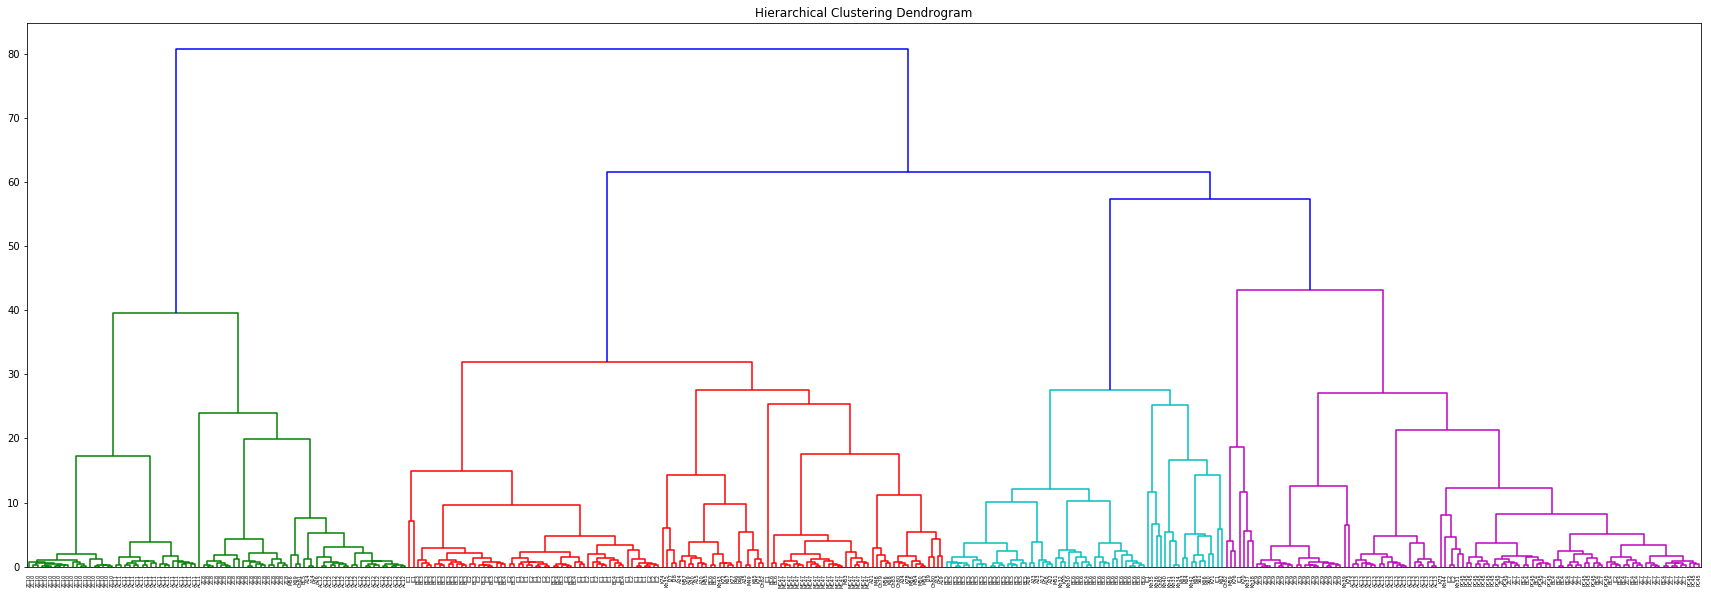

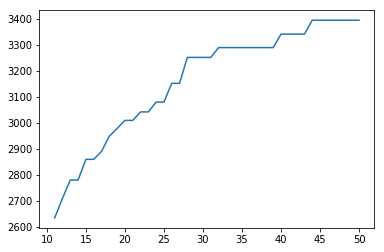

In [7]:
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree
D = pdist(X_t_mds)
agl = linkage(D, method='ward')
plt.figure(figsize=(30,10))
dendrogram(agl, labels=tocluster.POPUL_CODE.values)
plt.title('Hierarchical Clustering Dendrogram')
plt.gcf().savefig('main.png', dpi=300)
plt.show()
elb = []
for h in np.arange(50, 10, step=-1):
    elb.append(RSS_elbow(X_t_mds, cut_tree(agl, height=h).ravel()))

figure()
plot(np.arange(50, 10, step=-1), elb)
show()
y_pred = cut_tree(agl, height=30).ravel()

Определение уровня "оптимального" обрезания дерева -- во многом экспертный процесс. Однако, в данном случае -- после длительного постоянного значения критерия AIC -- при пороге обрезания от 40 до 30 -- после 30 идет существенный скачок. Далее, мы используем уровень для выделения кластеров h=30.

Посчитаем приуроченность районов каждому из сформированных кластеров.

In [8]:
for val in np.unique(y_pred):
    print("Current cluster", val+1, Counter(tocluster.POPUL_CODE[y_pred==val]))

Current cluster 1 Counter({'BC3': 20, 'IC2': 17, 'IC1': 16, 'BC4': 5})
Current cluster 2 Counter({'BC5': 19, 'BC6': 16, 'IC1': 2, 'A23': 2, 'Ch82': 1, 'A22': 1, 'K63': 1, 'K64': 1, 'BC4': 1, 'Kh41': 1, 'K62': 1, 'Kh42': 1, 'Kh33': 1, 'A18': 1, 'Kh34': 1, 'Kh40': 1, 'K71': 1, 'Kh35': 1, 'Kh32': 1, 'Kh30': 1, 'K65': 1, 'K70': 1, 'K66': 1, 'S60': 1, 'A17': 1, 'Kh36': 1, 'M51': 1, 'A16': 1, 'S61': 1})
Current cluster 3 Counter({'MC47': 20, 'BC6': 4, 'A20': 2, 'Ch80': 2, 'A24': 2, 'P46': 2, 'A19': 2, 'A15': 2, 'K68': 1, 'IC1': 1, 'M55': 1, 'J27': 1, 'K72': 1, 'Ch79': 1, 'M49': 1, 'A25': 1, 'J28': 1, 'J29': 1, 'K65': 1, 'K78': 1, 'Ch83': 1, 'M56': 1, 'M57': 1, 'K77': 1, 'M54': 1, 'Ch82': 1, 'Kh43': 1, 'A21': 1, 'Kh35': 1, 'K67': 1, 'M58': 1, 'K74': 1, 'K71': 1, 'M52': 1, 'M48': 1, 'M53': 1, 'M50': 1})
Current cluster 4 Counter({'Kh38': 1, 'K70': 1, 'IC1': 1, 'Ch82': 1, 'K76': 1, 'Kh37': 1, 'M59': 1})
Current cluster 5 Counter({'ZC7': 20, 'AC13': 20, 'PC45': 20, 'ZC9': 20, 'BC4': 14, 'IC2': 3

Ищем характерные для найденных кластеров морфометрические особенности. Для этого вычислим вариацию каждого из признаков для каждого кластера.

In [9]:
import copy
col_names = tocluster.columns[13:]
un = {cl+1: set() for cl in np.unique(y_pred)}
for cl in np.unique(y_pred):
    values = tocluster.iloc[y_pred==cl, 13:].values
    res = variation(values, axis=0)
    res[np.isnan(res)] = 0.0
    inds = np.argsort(res)
    if not un[cl+1]:
        un[cl+1] = set(col_names.values[res==0.0])
    
 
uniq = copy.deepcopy(un)    
for cli in range(len(np.unique(y_pred))):
    for j in [x for x in range(len(np.unique(y_pred))) if x!=cli]:
        uniq[cli+1] = uniq[cli+1] - un[j+1]


/home/dmitry/.pyenv/versions/3.5.4/envs/sci/lib/python3.5/site-packages/scipy/stats/stats.py:998: RuntimeWarning: invalid value encountered in true_divide
  return a.std(axis) / a.mean(axis)


Найдены следующие особенности (Указан номер кластера и морфометрические признаки, которые постоянны только для этого кластера):

In [10]:
print(uniq)

{1: {'Dc_Re'}, 2: set(), 3: set(), 4: {'Dnns_ORe'}, 5: set(), 6: {'Dnns_Re'}, 7: set()}


Исследование постоянства пар признаков внутри кластеров, позволяет сделать вывод, что 7-й кластер обладает
уникальным набором из 63 пар качественных признаков, которые его однозначно характеризуют.
Кластера № 2, 3, 5  такими наборами не обладают.
Более того, рассмотрение триплетов признаков и наборов признаков еще более высоких порядков, существенно не изменяют картины.

In [11]:
from itertools import combinations
col_names = tocluster.columns[13:]
un = {cl+1: set() for cl in np.unique(y_pred)}
for cl in np.unique(y_pred):
    values = tocluster.iloc[y_pred==cl, 13:].values
    res = variation(values, axis=0)
    res[np.isnan(res)] = 0.0
    inds = np.argsort(res)
    if not un[cl+1]:
        un[cl+1] = set(list(combinations(col_names.values[res<=0.01],2)))
    
uniq = copy.deepcopy(un)    
for cli in range(len(np.unique(y_pred))):
    for j in [x for x in range(len(np.unique(y_pred))) if x!=cli]:
        uniq[cli+1] = uniq[cli+1] - un[j+1]

/home/dmitry/.pyenv/versions/3.5.4/envs/sci/lib/python3.5/site-packages/scipy/stats/stats.py:998: RuntimeWarning: invalid value encountered in true_divide
  return a.std(axis) / a.mean(axis)


### Пример уникальных пар признаков, характеризующих 7-й кластер:

In [12]:
print([len(uniq[k]) for k in uniq])
print(uniq[7])

[30, 0, 0, 20, 0, 26, 63]
{('Dvl_Re', 'Dnn_O'), ('Dvl_Re', 'Dnvs_Re'), ('Dp_ORe', 'Dvl_G'), ('Dp_Re', 'Dvns_Re'), ('Dp_Re', 'Dnl_ORe'), ('Dnl_ORe', 'Dvvs_Re'), ('Dp_G', 'Dvns_ORe'), ('Dnl_ORe', 'Dvns_G'), ('Dvns_Re', 'Dnvs_ORe'), ('Dp_OG', 'Dnl_ORe'), ('Dp_G', 'Dnl_ORe'), ('Dp_OG', 'Dvns_ORe'), ('Dnl_Re', 'Dnvs_Re'), ('Dnl_ORe', 'Dvvs_ORe'), ('Dnl_ORe', 'Dnvs_G'), ('Dvl_Re', 'Dvvs_ORe'), ('Dc_OG', 'Dvvs_ORe'), ('Dvns_Re', 'Dvns_ORe'), ('Dnl_ORe', 'Dvns_Re'), ('Dnl_G', 'Dvns_ORe'), ('Dvns_ORe', 'Dvvs_ORe'), ('Dvns_ORe', 'Dnvs_G'), ('Dp_Re', 'Dvl_G'), ('Dp_ORe', 'Dvns_Re'), ('Dvns_Re', 'Dnvs_Re'), ('Dnl_O', 'Dvns_Re'), ('Dnl_Re', 'Dvvs_ORe'), ('Dvl_Re', 'Dvvs_O'), ('Dvns_Re', 'Dnn_O'), ('Dvl_OG', 'Dvns_ORe'), ('Dvl_Re', 'Dnl_ORe'), ('Dvl_OG', 'Dnl_ORe'), ('Dvns_ORe', 'Dvns_OG'), ('Dnl_ORe', 'Dnns_OG'), ('Dvl_G', 'Dnvs_ORe'), ('Dvns_Re', 'Dvvs_ORe'), ('Dc_OG', 'Dnvs_Re'), ('Dvns_G', 'Dvns_ORe'), ('Dvl_G', 'Dvvs_ORe'), ('Dvl_Re', 'Dvns_ORe'), ('Dvl_Re', 'Dnvs_ORe'), ('Dvns_ORe', 'Dnvs_Re')

#### Исследование важности признаков в образовании кластеров при помощи дерева решений

In [13]:
from sklearn.tree import DecisionTreeClassifier
dct = DecisionTreeClassifier()
dct.fit(X, y_pred)
inds = np.argsort(dct.feature_importances_)[::-1]
for feature, val in zip(col_names.values[inds], dct.feature_importances_[inds]):
    print(feature,' : ', val)
# Чем больше значение, тем больше вклад переменной в разделение по кластерам.
# Значения могут быть интерпретированы как доли.

Dp_ORe  :  0.25696874319912977
Dnns_Re  :  0.2214886191913935
Dnl_ORe  :  0.17682933096945577
Dvsh/Dosh  :  0.1454857204228518
Dnns_OG  :  0.033828241271170185
Dnl_Re  :  0.026418130006123385
Dvvs_ORe  :  0.02021148923066041
Dvvs_Re  :  0.0161683634343193
Dvns_Re  :  0.015141877599011937
Ср.зн S2p3l-S2p4l  :  0.012211028935318677
Dvl_ORe  :  0.011632401747207179
Lkd/L1p1l  :  0.010439911819543778
Dc_G  :  0.009373216283906608
Dnvs_Re  :  0.007613935689081061
Dc_OG  :  0.006280202056469928
Dnn_O  :  0.006186322747378357
Dvl_OG  :  0.006083386116830048
Dc_Re  :  0.005975323350334258
Dvl_G  :  0.005438525492200759
Dvl_Re  :  0.0031724732037837758
Dp_OG  :  0.003052757233829664
Dp_Re  :  0.0
Dp_O  :  0.0
Dvl_O  :  0.0
Dp_G  :  0.0
Dpl/Lp  :  0.0
Dnl_OG  :  0.0
Сp_W  :  0.0
Dnl_G  :  0.0
Dnl_O  :  0.0
Dnvs_ORe  :  0.0
Dnvs_G  :  0.0
Dnvs_OG  :  0.0
Dvvs_OG  :  0.0
Dvvs_G  :  0.0
Dvvs_O  :  0.0
Dnns_G  :  0.0
Dnns_ORe  :  0.0
Dvns_O  :  0.0
Dvns_OG  :  0.0
Dvns_ORe  :  0.0
Dvns_G  :  0.0
Dc_

Parameter: ALT
Kruskall-Wallis test:  KruskalResult(statistic=63.129357655365816, pvalue=1.0387405999574221e-11)
Parameter: IC
Kruskall-Wallis test:  KruskalResult(statistic=48.465282058639694, pvalue=9.538382273155941e-09)
Parameter: PN
Kruskall-Wallis test:  KruskalResult(statistic=30.607346514553647, pvalue=3.0121102971646836e-05)
Parameter: WK
Kruskall-Wallis test:  KruskalResult(statistic=94.58111354367621, pvalue=3.3795024998213314e-18)
Parameter: CK
Kruskall-Wallis test:  KruskalResult(statistic=100.42458274249499, pvalue=2.0462698845302198e-19)
Parameter: IOE
Kruskall-Wallis test:  KruskalResult(statistic=31.169887222775124, pvalue=2.3524425959777803e-05)
Parameter: Ann_PREC
Kruskall-Wallis test:  KruskalResult(statistic=158.9126744363211, pvalue=1.0062567317569509e-31)


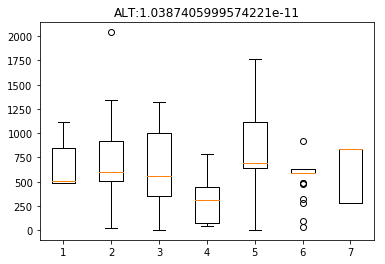

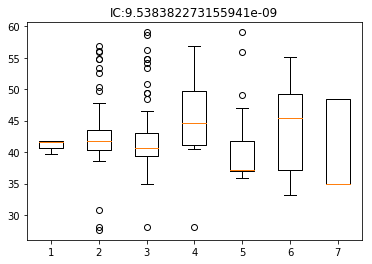

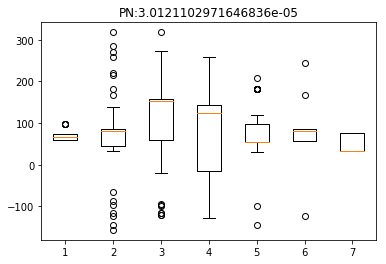

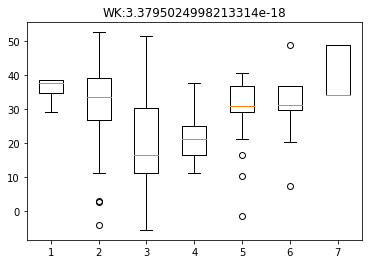

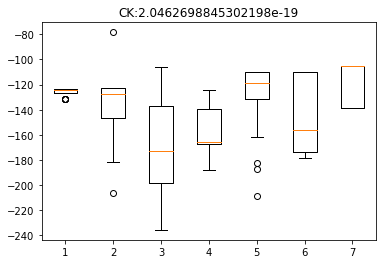

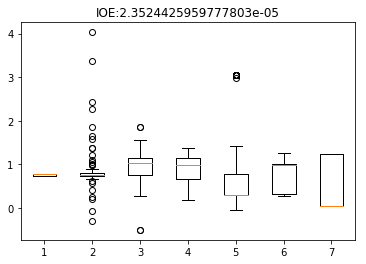

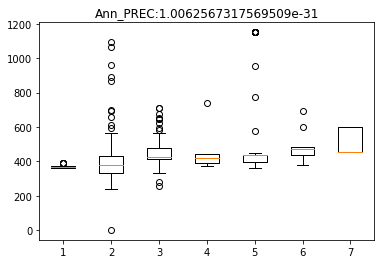

In [14]:
for par in tocluster.columns[6:13]:
    print("Parameter:", par)
    kr = kruskal(*[tocluster.loc[y_pred==val, par].values for val in np.unique(y_pred)])
    figure()
    boxplot([tocluster.loc[y_pred==val, par].values for val in np.unique(y_pred)])
    title(par + ':' + str(kr.pvalue))
    print("Kruskall-Wallis test: ", kr)
show()

In [15]:
from sklearn.tree import DecisionTreeClassifier
dct = DecisionTreeClassifier()
factors = StandardScaler().fit_transform(tocluster.iloc[:,6:13].values)
dct.fit(factors,y_pred)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

Вклады факторов среды в разделение по кластерам. 

In [16]:
inds = np.argsort(dct.feature_importances_)[::-1]
for feature, val in zip(tocluster.columns[6:13].values[inds], dct.feature_importances_[inds]):
    print(feature,' : ', val)


CK  :  0.36812220566135695
ALT  :  0.2705311703455354
Ann_PREC  :  0.21285202988450808
WK  :  0.07956643023820284
IOE  :  0.027809649826040984
IC  :  0.02732717029348449
PN  :  0.013791343750871205


Попарное сравнение -- выяснение значимых различий по условиям среды, характерных для выделенных кластеров

Comparison by var: 6
Comparison by var: 7
Comparison by var: 8
Comparison by var: 9
Comparison by var: 10
Comparison by var: 11
Comparison by var: 12


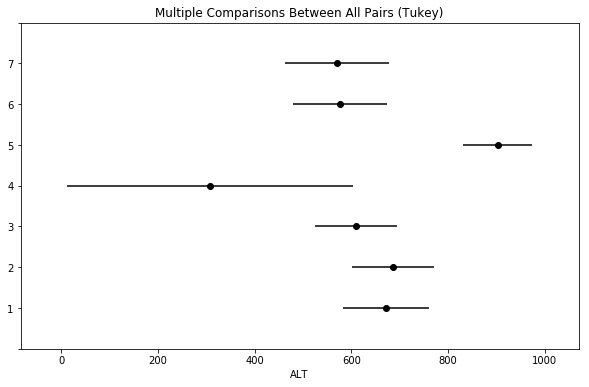

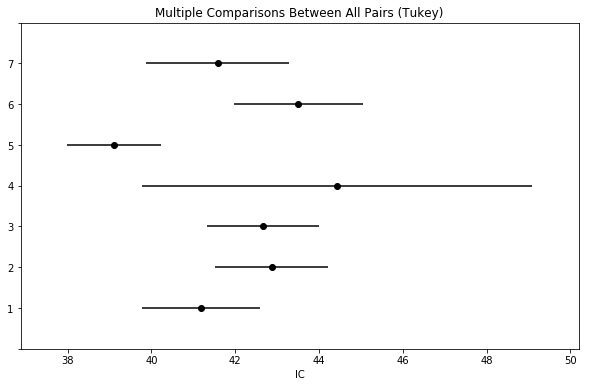

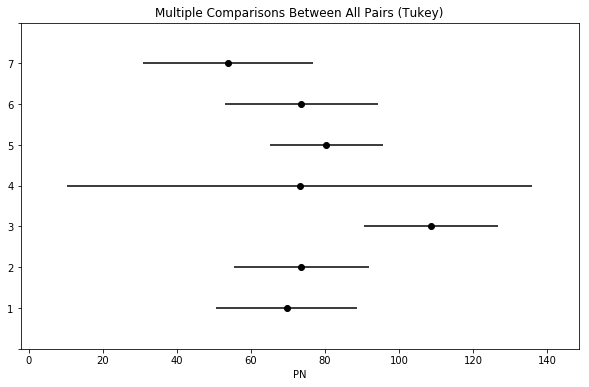

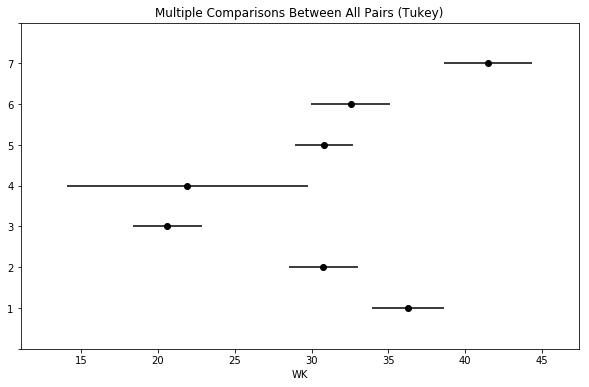

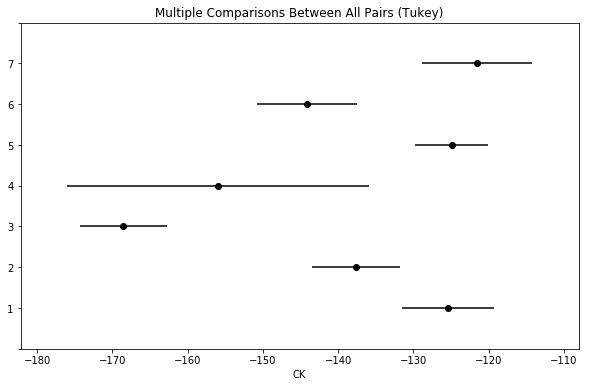

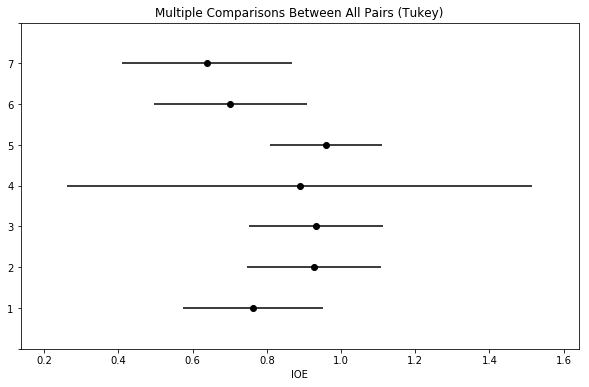

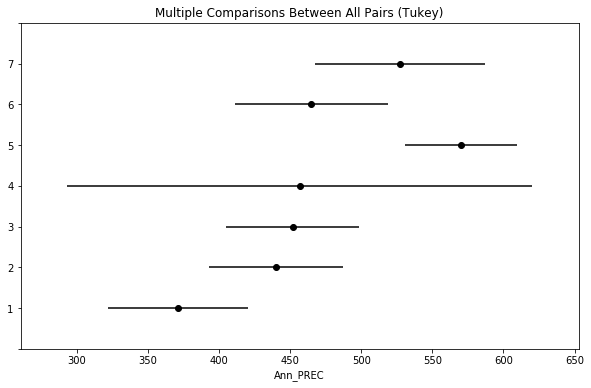

In [17]:
from statsmodels.stats.multicomp import (pairwise_tukeyhsd,
                                         MultiComparison)
for var in range(6, 13):
    res = pairwise_tukeyhsd(tocluster.iloc[:,var], y_pred+1, alpha=0.05)
    print('Comparison by var: %s' % var)
    res.plot_simultaneous(xlabel=tocluster.columns[var])
show()

По фактору <ALT> можно сделать следующие выводы: 5-й кластер имеет значимо отличающиеся высоты от остальных кластеров, 4-й кластер -- самою большую изменчивость этого параметра; 
По оси ординат -- идут кластера, каждая картинка соответствует определенному фактору среды. Если интервалы не накрываюся, то значит соответствующие кластера имеют значимые различия по данному фактору среды. 
Уровень значимости принимается равным 0.05. (Значение по умолчанию для используемой функции).
    
    Далее, здесь необходимо описание результатов: Например,такое -- По параметру Ann_PREC 5 и 1 кластера значимо отличаются. Это вызвано тем, что представители 5-го кластера находятся преимущественно в таких-то условиях -- в данном случае -- более влажных, а для сборов, принадлежащих кластеру 1, характерны наоборот, более сухие местообитания. и т.п. почему ... 

## Регрессионные модели, оценка точности регрессионных моделей


In [18]:
from sklearn import linear_model
lr = linear_model.ElasticNet(alpha=.0)
lgr = linear_model.LogisticRegressionCV(cv=10)

In [19]:
num_vars = tocluster.columns[13:18]
non_num_vars = tocluster.columns[18:]

Попытка предсказать значения количественных признаков по факторам среды. Ниже приводятся значения коэффициентов детерминации (R2). 

In [20]:
print(tocluster.columns[6:13].values)
for var in num_vars:
    y=tocluster.loc[:,var].values
    lr.fit(factors, y)
    print(var, lr.score(factors, y))
    print(lr.coef_)

['ALT' 'IC' 'PN' 'WK' 'CK' 'IOE' 'Ann_PREC']
Wkd/Lkd 0.06087961813792453
[-0.00034462 -0.00742293 -0.01031393 -0.00369036 -0.00077191  0.01816475
 -0.00638903]
Dvsh/Dosh 0.21284478317899735
[ 0.00287272  0.04104924  0.01303437 -0.01666457  0.06135575  0.03248572
 -0.07135281]
Lkd/L1p1l 0.08307711498351211
[-0.00391133 -0.01672971 -0.02101327  0.01777155 -0.02626376  0.01600315
  0.00852524]
Dpl/Lp 0.15584257101993115
[ 0.00183378 -0.04141584 -0.03290279  0.03151611 -0.03672373  0.02085478
  0.00672552]
Ср.зн S2p3l-S2p4l 0.0940775691782022
[ 0.01479744  0.0419665   0.01491399 -0.02376094  0.03309094  0.02570209
 -0.01809798]


/home/dmitry/.pyenv/versions/3.5.4/envs/sci/lib/python3.5/site-packages/ipykernel_launcher.py:4: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  after removing the cwd from sys.path.
/home/dmitry/.pyenv/versions/3.5.4/envs/sci/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:477: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/dmitry/.pyenv/versions/3.5.4/envs/sci/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Dvsh/Dosh 0.21284478317899735
[ 0.00287272  0.04104924  0.01303437 -0.01666457  0.06135575  0.03248572
 -0.07135281]
Количество осадков и холодовой индекс Кира определяют форму листа (его обратнояйцевидность).


Dpl/Lp 0.15584257101993115
[ 0.00183378 -0.04141584 -0.03290279  0.03151611 -0.03672373  0.02085478
  0.00672552]
Скученность листиков зависит от индекса континентальности.
  

In [21]:
tocluster.columns[6:13].values

array(['ALT', 'IC', 'PN', 'WK', 'CK', 'IOE', 'Ann_PREC'], dtype=object)

## Логистическая регрессия: предсказание значений качественных признаков по факторам среды.

Dp_G: -- достаточно хорошо предсказывается по факторам среды (с точностью 0.91 +/- 0.08); При этом коэффициенты, соответствующие параметрам IC и CK имеют больший порядок вклада в регрессионную модель.

In [22]:
for var in non_num_vars:
    y=tocluster.loc[:,var].values
    if len(np.unique(y))>1:
        lgr.fit(factors, y)
        print(var, np.mean(lgr.scores_[1]),'+/-', np.std(lgr.scores_[1]))
        print(lgr.coef_.ravel())

Dp_G 0.9091946602472918 +/- 0.07965122181547842
[-6.88807990e-04 -1.52437799e-03 -2.86733539e-05  8.13188473e-04
  1.56036825e-03 -8.44806753e-04 -1.23708979e-04]


/home/dmitry/.pyenv/versions/3.5.4/envs/sci/lib/python3.5/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 6 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


Dp_OG 0.9504504504504506 +/- 0.15005945516830205
[-1.00246421e-03  3.65209007e-04 -1.29488935e-04 -1.12560740e-03
 -4.53503184e-04  1.10125545e-04  3.86327945e-05]
Dp_ORe 0.7544330160119634 +/- 0.14625950459177767
[ 0.42961099 -0.1467596   1.34880601  2.5489009  -1.7432406  -2.91866762
  1.9416989 ]
Dp_Re 0.6306781376518218 +/- 0.15014679482175636
[ 0.00446541 -0.00079136  0.0019244  -0.00409907 -0.00177574  0.00302916
 -0.00058112]
Dvl_Re 0.6702436444541705 +/- 0.17992030011225826
[ 0.0041929  -0.00292531  0.0005556  -0.00365843  0.00073532  0.00102881
 -0.00093211]
Dvl_OG 0.9306612685560052 +/- 0.13033145681304317
[-0.00142431  0.00019499  0.00090811 -0.00061104 -0.00060915  0.00070159
  0.00010529]
Dvl_ORe 0.6808063427800269 +/- 0.21923225231989688
[-0.00256975  0.00273317 -0.00139246  0.00400675 -0.00032463 -0.0016827
  0.00104366]


/home/dmitry/.pyenv/versions/3.5.4/envs/sci/lib/python3.5/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


Dvl_G 0.9604719699456541 +/- 0.13677554822086166
[-2.11427722e-04  5.01992353e-06 -6.94074046e-05  2.63067739e-04
  1.91908129e-04 -4.66002758e-05 -2.19012983e-04]
Dnl_ORe 0.5461673414304992 +/- 0.14847169422684078
[ 0.99999015  0.93691268  0.74583787 -0.13439149  1.01492657 -0.56163966
  0.1001139 ]
Dnl_OG 0.9104147062041801 +/- 0.12354734887038538
[-0.0029367   0.00195353 -0.00035415 -0.00252359 -0.0015879   0.00013502
  0.00068013]
Dnl_Re 0.7182860998650472 +/- 0.12151502985511899
[-0.11221775 -0.43202688 -0.30327812  0.07994602 -0.71521821  0.672565
 -1.19239197]
Dnl_G 0.9604719699456541 +/- 0.13677554822086166
[-2.11427722e-04  5.01992353e-06 -6.94074046e-05  2.63067739e-04
  1.91908129e-04 -4.66002758e-05 -2.19012983e-04]
Dnl_O 0.9315384615384613 +/- 0.05422712326779201
[ 19.31192651 -12.25200941   2.9662523   40.12991989 -16.46758477
 -10.54244921   1.74714149]
Dc_G 0.7949903344640186 +/- 0.1455928700689411
[ 0.0023725  -0.00234665 -0.00401067  0.00290047  0.0072553  -0.00229838

/home/dmitry/.pyenv/versions/3.5.4/envs/sci/lib/python3.5/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


Dc_OG 0.9666329284750339 +/- 0.11807500932182834
[-1.58599547e-04  3.79240799e-06 -5.21036579e-05  1.97314376e-04
  1.43941863e-04 -3.49741816e-05 -1.64313982e-04]
Dvns_Re 0.664155450997556 +/- 0.18394961941407692
[ 0.00286646 -0.00347274  0.00068043  0.00108807  0.0038241   0.00184683
  0.00102195]
Dvns_G 0.9427234927234929 +/- 0.12711009473273044
[ 0.000226    0.00030662  0.00036306 -0.00065196 -0.00097876  0.00012326
 -0.00013732]
Dvns_ORe 0.7089610460663089 +/- 0.16176426288823248
[-0.0021547   0.00252444 -0.00055518 -0.0002056  -0.00261698 -0.00188972
 -0.00122824]


/home/dmitry/.pyenv/versions/3.5.4/envs/sci/lib/python3.5/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 5 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


Dvns_OG 0.9482605682605683 +/- 0.15648919987938614
[-0.00082912  0.00052739 -0.00048755 -0.00041399 -0.00024078 -0.00013821
  0.00027578]


/home/dmitry/.pyenv/versions/3.5.4/envs/sci/lib/python3.5/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


Dvns_O 0.9796052631578946 +/- 0.08595892612526879
[-1.17531732e-04  1.30806913e-04 -3.82692587e-06  1.73335114e-04
 -5.37948427e-06  5.75810700e-05  6.48565481e-05]
Dnns_Re 0.6363668526826423 +/- 0.24484029084201556
[ 0.32853034 -0.50719957 -0.2001719  -0.42238795  0.1366599  -0.1627542
 -0.01567647]
Dnns_OG 0.9102665317138999 +/- 0.15065594001697527
[-0.0014571   0.00171983 -0.00089463 -0.00176863 -0.00156136 -0.00014236
  0.00098704]
Dnns_ORe 0.7768322573585733 +/- 0.12236405481102908
[ 0.09949811  1.22930703  0.65025623  1.02351092 -0.09277476  0.7814657
 -0.77068663]
Dnn_O 0.932845141700405 +/- 0.07061603218230231
[  55.02879674   43.23679316  229.81316258  228.89581595   23.38582253
 -179.37949647 -121.6325729 ]
Dvvs_ORe 0.6908906882591092 +/- 0.15271858436509728
[ 1.14539329 -3.93556647 -4.11617705  3.66156569 -4.08248404  2.95303039
 -0.82034385]
Dvvs_Re 0.8001012145748989 +/- 0.11991532471333803
[-0.00174774  0.00355867 -0.00031979 -0.0033597  -0.00251489  0.00157012
  0.001404


# Осредненные данные 

In [23]:
import pandas as pd
from pylab import *
mdata = pd.read_excel('cluster_mean.xlsx')

In [24]:
X = mdata.iloc[:,12:].values
X = StandardScaler().fit_transform(X)

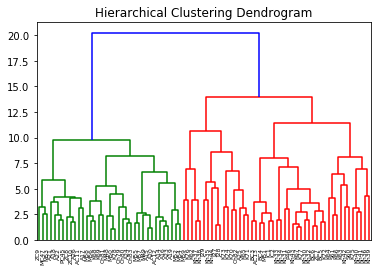

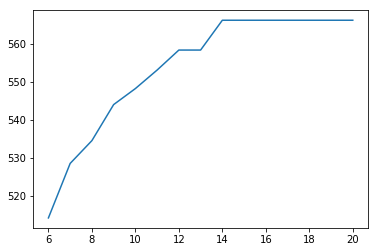

In [25]:
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree
D = pdist(X)
agl = linkage(D, method='ward')
#plt.figure(figsize=(30,10))
dendrogram(agl, labels=mdata.POPUL_CODE.values)
plt.title('Hierarchical Clustering Dendrogram')
plt.gcf().savefig('main_mean.png', dpi=300)
elb = []
for h in np.arange(20, 5, step=-1):
    elb.append(RSS_elbow(X, cut_tree(agl, height=h).ravel()))

figure()
plot(np.arange(20, 5, step=-1), elb)
show()
y_pred = cut_tree(agl, height=8.0).ravel()

In [26]:
for val in np.unique(y_pred):
    print("Current cluster", val+1, Counter(mdata.POPUL_CODE[y_pred==val]))

Current cluster 1 Counter({'K77': 1, 'P46': 1, 'IC1': 1, 'Kh34': 1, 'BC3': 1, 'IC2': 1, 'Kh43': 1, 'K72': 1, 'Kh32': 1, 'Kh30': 1, 'ZC7': 1, 'BC5': 1, 'AC13': 1, 'K67': 1, 'M51': 1, 'BC4': 1, 'Kh31': 1, 'Kh33': 1, 'BC6': 1})
Current cluster 2 Counter({'A21': 1, 'A26': 1, 'ZC9': 1, 'ZC10': 1, 'A22': 1, 'M53': 1, 'A17': 1, 'ZC8': 1, 'PC45': 1, 'AC11': 1, 'MC47': 1, 'A18': 1})
Current cluster 3 Counter({'M54': 1, 'A14': 1, 'A20': 1, 'A19': 1, 'M55': 1, 'M49': 1, 'M57': 1, 'AC12': 1, 'M52': 1, 'A15': 1, 'A16': 1, 'A23': 1})
Current cluster 4 Counter({'K68': 1, 'K69': 1, 'M50': 1, 'Ch83': 1, 'A24': 1, 'M58': 1, 'Ch79': 1, 'K78': 1, 'Ch80': 1, 'M48': 1, 'Ch81': 1, 'M56': 1})
Current cluster 5 Counter({'K70': 1, 'Ch82': 1, 'K73': 1, 'K71': 1, 'A25': 1, 'K65': 1, 'K74': 1})
Current cluster 6 Counter({'J27': 1, 'J28': 1, 'J29': 1, 'Kh44': 1, 'Kh35': 1})
Current cluster 7 Counter({'Kh41': 1, 'Kh36': 1, 'Kh40': 1, 'Kh39': 1, 'K75': 1})
Current cluster 8 Counter({'Kh38': 1, 'Kh37': 1, 'K62': 1, 'K

In [27]:
from sklearn.tree import DecisionTreeClassifier
dct = DecisionTreeClassifier()
dct.fit(X, y_pred)
inds = np.argsort(dct.feature_importances_)[::-1]
for feature, val in zip(col_names.values[inds], dct.feature_importances_[inds]):
    print(feature,' : ', val)
# Чем больше значение, тем больше вклад переменной в разделение по кластерам.
# Значения могут быть интерпретированы как доли.

Dvl_Re  :  0.19427770211968326
Dp_O  :  0.16647516529592005
Dpl/Lp  :  0.13917815066499617
Dvl_OG  :  0.12781035523860404
Dp_ORe  :  0.1010471758450195
Dp_G  :  0.08699423404301758
Lkd/L1p1l  :  0.08226056288724755
Dp_OG  :  0.048080105925190325
Wkd/Lkd  :  0.03989406819595501
Dvsh/Dosh  :  0.01398247978436658
Dvl_ORe  :  0.0
Dp_Re  :  0.0
Ср.зн S2p3l-S2p4l  :  0.0


Parameter: ALT
Kruskall-Wallis test:  KruskalResult(statistic=18.389487835581455, pvalue=0.018488663029593726)
Parameter: IC
Kruskall-Wallis test:  KruskalResult(statistic=10.092369477911632, pvalue=0.25860257235182854)
Parameter: PN
Kruskall-Wallis test:  KruskalResult(statistic=7.598629749934219, pvalue=0.47362502184028443)
Parameter: WK
Kruskall-Wallis test:  KruskalResult(statistic=23.874854951492296, pvalue=0.002405153033521283)
Parameter: CK
Kruskall-Wallis test:  KruskalResult(statistic=14.722328195704392, pvalue=0.06477487526896614)
Parameter: IOE
Kruskall-Wallis test:  KruskalResult(statistic=9.193565022711653, pvalue=0.32623124467652753)
Parameter: Ann_PREC
Kruskall-Wallis test:  KruskalResult(statistic=7.0612516661706195, pvalue=0.5300387448756069)


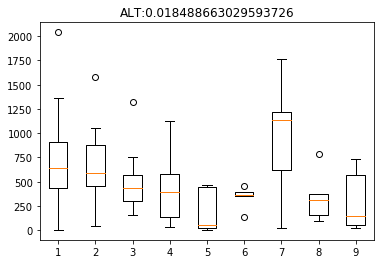

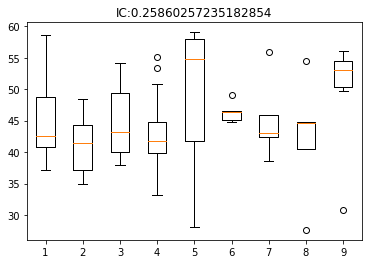

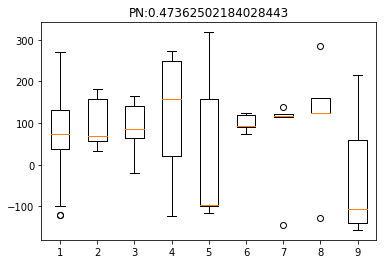

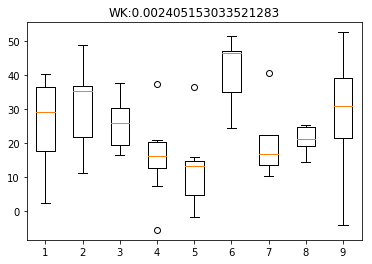

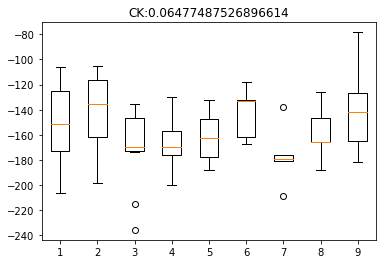

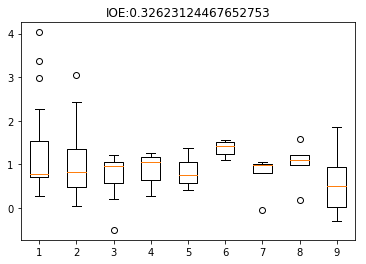

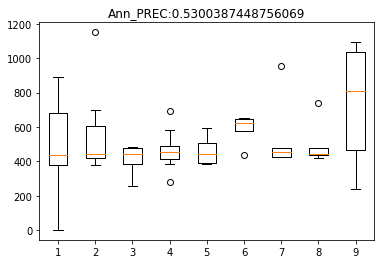

In [28]:
for par in mdata.columns[5:12]:
    print("Parameter:", par)
    kr = kruskal(*[mdata.loc[y_pred==val, par].values for val in np.unique(y_pred)])
    figure()
    boxplot([mdata.loc[y_pred==val, par].values for val in np.unique(y_pred)])
    title(par + ':' + str(kr.pvalue))
    print("Kruskall-Wallis test: ", kr)
show()

Comparison by var: 5
Comparison by var: 6
Comparison by var: 7
Comparison by var: 8
Comparison by var: 9
Comparison by var: 10
Comparison by var: 11


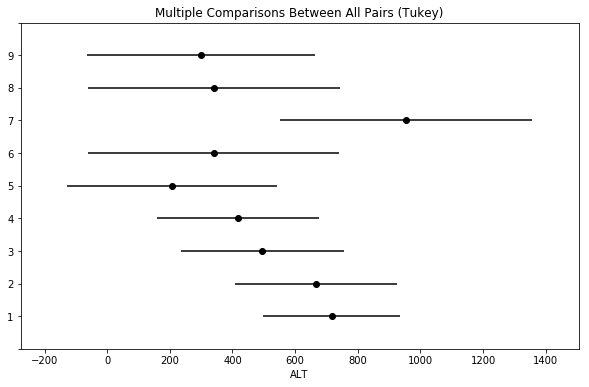

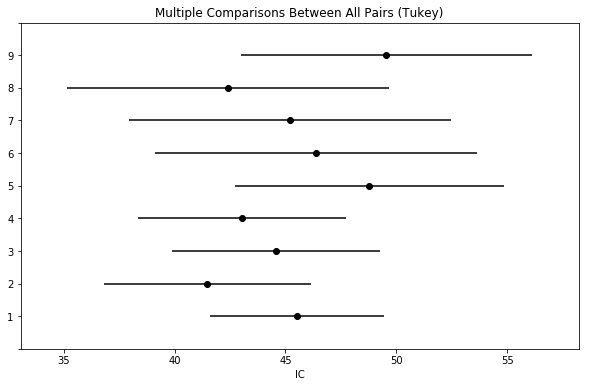

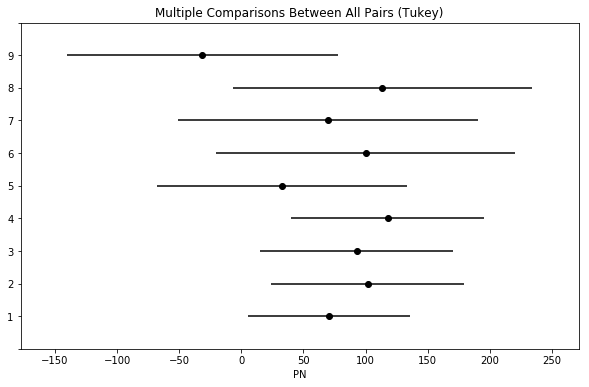

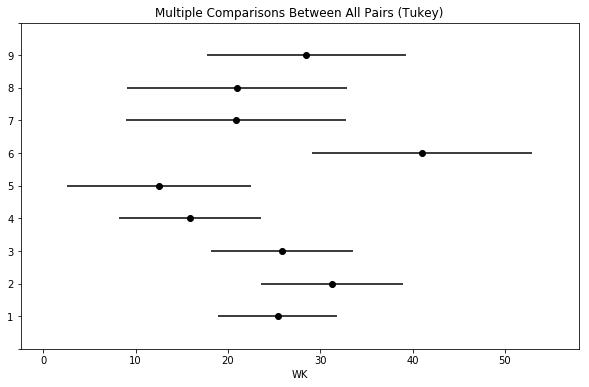

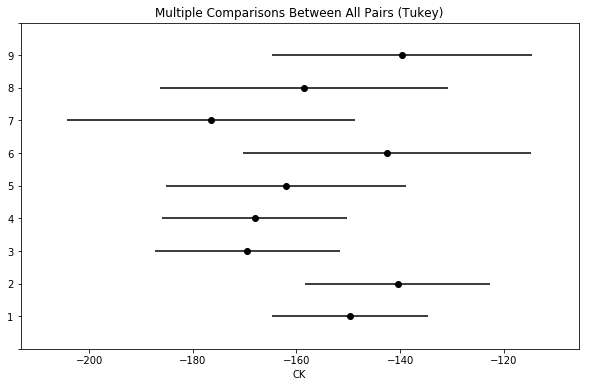

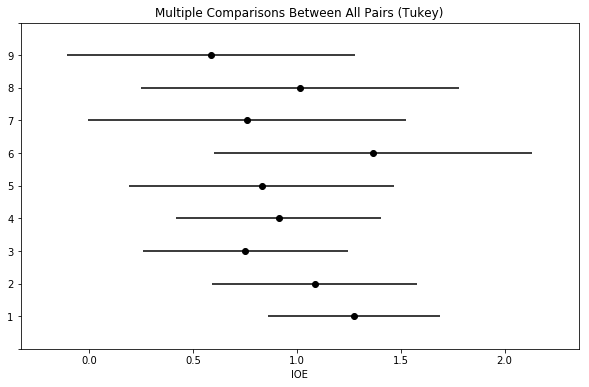

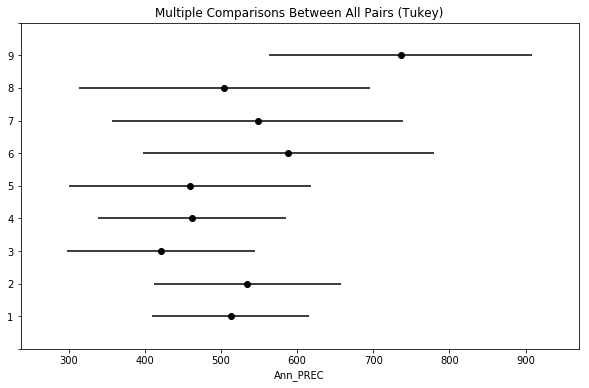

In [29]:
from statsmodels.stats.multicomp import (pairwise_tukeyhsd,
                                         MultiComparison)
for var in range(5, 12):
    res = pairwise_tukeyhsd(mdata.iloc[:,var], y_pred+1, alpha=0.05)
    print('Comparison by var: %s' % var)
    res.plot_simultaneous(xlabel=mdata.columns[var])
show()

In [30]:
from sklearn.tree import DecisionTreeClassifier
dct = DecisionTreeClassifier()
factors = StandardScaler().fit_transform(mdata.iloc[:,5:12].values)
dct.fit(factors, y_pred)
inds = np.argsort(dct.feature_importances_)[::-1]
for feature, val in zip(mdata.columns[5:12].values[inds], dct.feature_importances_[inds]):
    print(feature,' : ', val)


IOE  :  0.22062683712873468
IC  :  0.18736239974505398
WK  :  0.18644152691072693
ALT  :  0.1588389982369311
Ann_PREC  :  0.1366706303953609
CK  :  0.05658721519570578
PN  :  0.05347239238748675


In [41]:
from sklearn import linear_model
lr = linear_model.LinearRegression()
num_vars = mdata.columns[12:].values
print(mdata.columns[5:12].values)
for var in num_vars:
    y=mdata.loc[:,var].values
    lr.fit(factors, y)
    print('Variable:', var, 'R2=', lr.score(factors, y))
    print(lr.coef_)


['ALT' 'IC' 'PN' 'WK' 'CK' 'IOE' 'Ann_PREC']
Variable: Wkd/Lkd R2= 0.09049172609854328
[-0.00352387 -0.02325071 -0.02903044  0.01050906 -0.0226397   0.01430082
  0.00512144]
Variable: Dvsh/Dosh R2= 0.03510110396477939
[ 0.00348575  0.02054728  0.01656261 -0.0083917   0.02765023  0.00466618
 -0.01110402]
Variable: Lkd/L1p1l R2= 0.14774989833406427
[-0.00921647 -0.02156674 -0.03693703  0.02123506 -0.01787719  0.02441684
 -0.00132744]
Variable: Dpl/Lp R2= 0.09481474238595955
[-0.00011681 -0.01297784 -0.02155012  0.0107126  -0.00348021  0.00992887
  0.00069149]
Variable: Ср.зн S2p3l-S2p4l R2= 0.1651850937547258
[-0.00071818 -0.02687667 -0.07007172  0.01486481 -0.00246629  0.08292496
 -0.00885949]
Variable: Dp R2= 0.1688090733601879
[-0.07692505 -0.0562766  -0.08065085 -0.06012817  0.00107406  0.07821062
  0.00375442]
Variable: Dvl R2= 0.1134243668309073
[-0.08508156 -0.01860608 -0.03567715  0.00557019  0.01147795  0.09148127
 -0.02789634]
Variable: Dnl R2= 0.22872148406107706
[-0.12258319 

## ['ALT' 'IC' 'PN' 'WK' 'CK' 'IOE' 'Ann_PREC']

Variable: Dnl R2= 0.22872148406107706
[-0.12258319  0.10886613  0.10265138 -0.13044222  0.08090473 -0.08334545
  0.06666848]
Наибольшее влияние на Dnl оказывают: тепловой индекс Кира (WK) и  высота (ALT). Далее идут индекс континетальности (IC)
    и количество снега (PN).

    
    Variable: Dvvs R2= 0.22974965527405833
[-0.00183077  0.04897154  0.01121221 -0.0286191   0.03093123  0.01557995
  0.04301794]

Индекс континетальности, количество осадков и холодовой индекс Кира определяют Dvvs.

In [53]:
ldr = LinearDiscriminantAnalysis(n_components=2)
ldr.fit(X, y_pred)

LinearDiscriminantAnalysis(n_components=2, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)

In [72]:
X_t = ldr.transform(X)
print(ldr.explained_variance_ratio_)

[0.44832077 0.21052683]


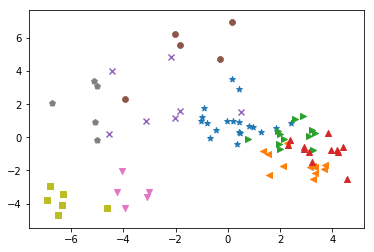

In [71]:
for y,m in zip(np.unique(y_pred), ["*","<",">","^","x","8",'v','p','s']):
    scatter(X_t[y_pred==y,0], X_t[y_pred==y,1], marker=m)
show()